## 2a. Detecting Lines

Our first task is to figure out where the chessboard lines are in the image. We'll be working with the following image from chess YouTuber IM Eric Rosen. Note that there is a significant amount of background captured in the image.

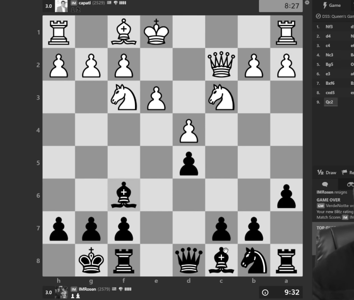

In [1]:
import numpy as np
from PIL import Image
img_name = 'images/youtube.png'
pil_img = Image.open(img_name).convert('L')
img = np.array(pil_img)
height, width = img.shape
display(pil_img.resize((int(width*300/height), 300)))

Since we know that the chessboard lines will be either horizontal or vertical, we can apply two filters to the image: one to detect vertical shifts in color, and one to horizontal shifts in color.

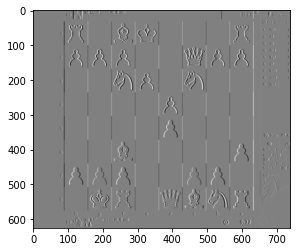

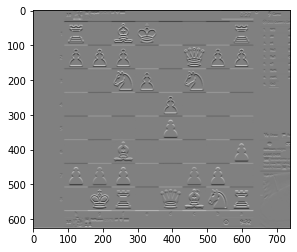

In [2]:
from scipy.signal import convolve
ker_x = np.array(np.mat('-1 0 1; -1 0 1; -1 0 1'))
grad_x = convolve(img, ker_x)
ker_y = np.array(np.mat('-1 -1 -1; 0 0 0; 1 1 1'))
grad_y = convolve(img, ker_y)

import matplotlib.pyplot as plt
plt.imshow(grad_x, 'gray')
plt.show()
plt.imshow(grad_y, 'gray')
plt.show()

The dark and light pixels above denote color shifts in the image. To find the rows/columns corresponding to lines, we can add together the number of light pixels and the number of dark pixels. Now here is where I hit a wall. This method detects the chessboard lines, but it also tends to pick up on extraneous lines. After some research, I came across a brilliant solution by GitHub user [Elucidation](https://github.com/Elucidation/tensorflow_chessbot) who was making a Reddit bot for FEN prediction. The idea is rather than add together the number of light & dark pixels, we multiply them! The quantity $x(1-x)$ is maximized when $x = 1/2$, so we'll get the largest response when there is an equal balance of light & dark pixels. This is exactly what happens for internal chessboard edges, but it's pretty rare for other edges in the image (including the external board edges).

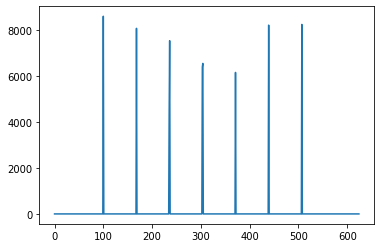

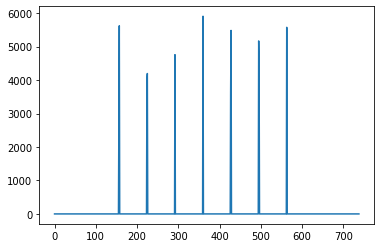

In [3]:
# Separate out the light pixels (positive) with the dark pixels (negative)
x_pos = np.clip(grad_x, 0, 255)
x_neg = np.clip(grad_x, -255, 0)
y_pos = np.clip(grad_y, 0, 255)
y_neg = np.clip(grad_y, -255, 0)

# For each row/col, multiply the average light and dark pixel intensities
row_sums = np.sum(y_pos/height, axis=1) * np.sum(-y_neg/height, axis=1)
row_sums[np.where(row_sums<np.max(row_sums)/2.)] = 0
col_sums = np.sum(x_pos/width, axis=0) * np.sum(-x_neg/width, axis=0)
col_sums[np.where(col_sums<np.max(col_sums)/2.)] = 0

plt.plot(row_sums)
plt.show()
plt.plot(col_sums)
plt.show()

Next, we pick out the peaks in response, which correspond to the internal edges of the board. I've also added a crude algorithm to handle the rare case that more than 7 peaks are detected. In this case, there are typically 1-2 extra lines due to the external edges of the board. This obviously has room for improvement.

In [4]:
from scipy.signal import find_peaks
all_cols = list(find_peaks(col_sums, distance=10)[0])
all_rows = list(find_peaks(row_sums, distance=10)[0])

def near_arith_prog(arr):
    diffs = [arr[i] - arr[i-1] for i in range(1,len(arr))]
    return max(diffs) - min(diffs) < 5

# TODO: Make this into a more robust algorithm
def get_lines(arr):
    if len(arr) < 7:
        return None
    elif len(arr) == 7:
        if near_arith_prog(arr):
            return arr
        else:
            return None
    elif len(arr) == 8:
        if near_arith_prog(arr[:7]):
            return arr[:7]
        elif near_arith_prog(arr[1:]):
            return arr[1:]
    elif len(arr) == 9:
        if near_arith_prog(arr[1:8]):
            return arr[1:8]
    return None

cols = get_lines(all_cols)
rows = get_lines(all_rows)

## 2b. Splitting into Squares

As a sanity check, let's draw the rows and columns that we've identified on the original image:

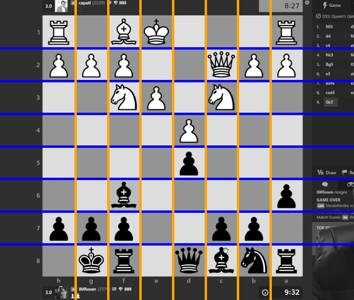

In [5]:
from PIL import ImageDraw
disp_img = pil_img.convert('RGB')
draw = ImageDraw.Draw(disp_img, mode='RGB')
for r in rows:
    draw.line((0,r,width,r), fill='blue', width=5)
for c in cols:
    draw.line((c,0,c,height), fill='orange', width=5)
del draw
display(disp_img.resize((int(width*300/height), 300)))

Nice! Now it's finally time to split up the board into squares:

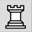

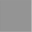

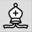

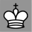

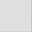

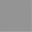

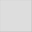

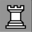

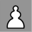

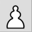

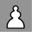

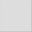

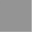

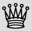

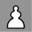

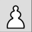

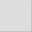

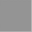

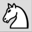

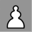

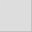

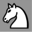

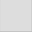

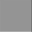

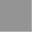

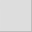

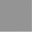

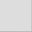

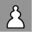

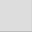

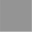

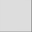

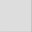

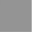

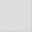

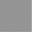

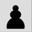

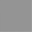

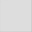

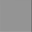

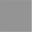

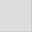

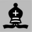

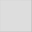

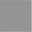

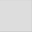

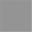

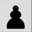

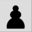

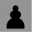

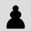

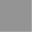

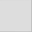

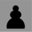

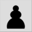

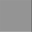

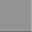

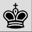

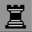

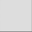

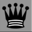

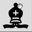

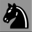

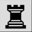

In [6]:
sq_height = rows[1] - rows[0]
sq_width = cols[1] - cols[0]
_rows, _cols = rows[:], cols[:]  # Make copies so that this code cell can be re-run
# Add left and right external edges
_cols.append(min(cols[6] + sq_width, width))
_cols.insert(0, max(cols[0] - sq_width, 0))
# Add top and bottom external edges
_rows.append(min(rows[6] + sq_height, height))
_rows.insert(0, max(rows[0] - sq_height, 0))

squares = []
# Traverse board in order described by FEN
for j in range(len(_rows)-1):
    for i in range(len(_cols)-1):
        area = (_cols[i], _rows[j], _cols[i+1], _rows[j+1])
        squares.append(pil_img.crop(area).resize((32,32)))
display(*squares)